# Autoencoder

In [1]:
import os
import random
import cv2
import numpy as np
import collections

import torch
import torchvision
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from utils import (
    Collector,
    AELoss,
    VAELoss,
    trainer,
    plot_latent_tsne,
    generate_samples_between_centers,
    visualize_prediction,
)

from models import (
    deconv_resnet18,
    resnet18,
)

%matplotlib inline

## Set Seeds

In [2]:
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Define basics params

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 80
bs = 256
num_workers = 8
mean = [0, 0, 0]
std = [1, 1, 1]
image_size = [128, 128]

## Define Generator for train/test data

In [4]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        dataset: torch.utils.data.Dataset,
        root: str,
        split: str,
        transform,
        download: bool,
    ) -> None:
        
        super().__init__()
        
        try:
            self.dataset = dataset(
                root=root,
                split=split,
                transform=transform,
                download=download,
            )
            
        except:
            self.dataset = dataset(
                root=root,
                train=split == 'train',
                transform=transform,
                download=download,
            )
            
        
    def __getitem__(
        self,
        idx: int,
    ) -> dict:
        
        images, classes = self.dataset.__getitem__(idx)
        
        return {
            'images': images,
            'class': classes,
        }
    
    def __len__(
        self,
    ) -> int:
        
        return len(self.dataset)

class Transforms:
    
    def __init__(
        self,
        transforms: A.Compose,
    ) -> None:
        
        self.transforms = transforms

    def __call__(
        self,
        img,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        
        return self.transforms(
            image=np.array(img),
            test_image=np.array(img),
        )
    
in_tf = A.Compose([
    A.LongestMaxSize(max_size=max(image_size)),
    A.PadIfNeeded(
        position=A.PadIfNeeded.PositionType.TOP_LEFT,
        min_height=image_size[0],
        min_width=image_size[1],
        value=0,
        border_mode=cv2.BORDER_CONSTANT,
    ),
], additional_targets = {
    'test_image': 'image',
})

middle_tf = A.Compose([
    A.CoarseDropout(
        max_holes=4,
        min_holes=1,
        max_height=0.2,
        min_height=0.05,
        max_width=0.2,
        min_width=0.05,
        fill_value=[0, 0.5, 1],
        p=0.5,
    ),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=(-0.5, 0.5),
            contrast_limit=(-0.5, 0.5),
            p=1,
        ),
        A.Blur(
            p=1,
        ),
        A.GaussNoise(
            var_limit=5.0 / 255.0,
            p=1,
        ),
    ], p=1)
])

out_tf = A.Compose([
    A.Normalize(
        mean=mean,
        std=std,
    ),
    ToTensorV2(),
], additional_targets = {
    'test_image': 'image',
})
    
transformations = {
    'unlabeled': A.Compose([
        in_tf,
        middle_tf,
        out_tf,
    ]),
    'test': A.Compose([
        in_tf,
        out_tf,
    ]),
}

datasets = {
    phase: MyDataset(
        dataset=torchvision.datasets.STL10,
        root='./data/',
        split=phase,
        transform=Transforms(transformations[phase]),
        download=True,
    )
    for phase in transformations
}

dataloaders = {
    phase: torch.utils.data.DataLoader(
        dataset=datasets[phase],
        batch_size=bs,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g,
    )
    for phase in transformations
}

Files already downloaded and verified
Files already downloaded and verified


## Lets visualize a batch!

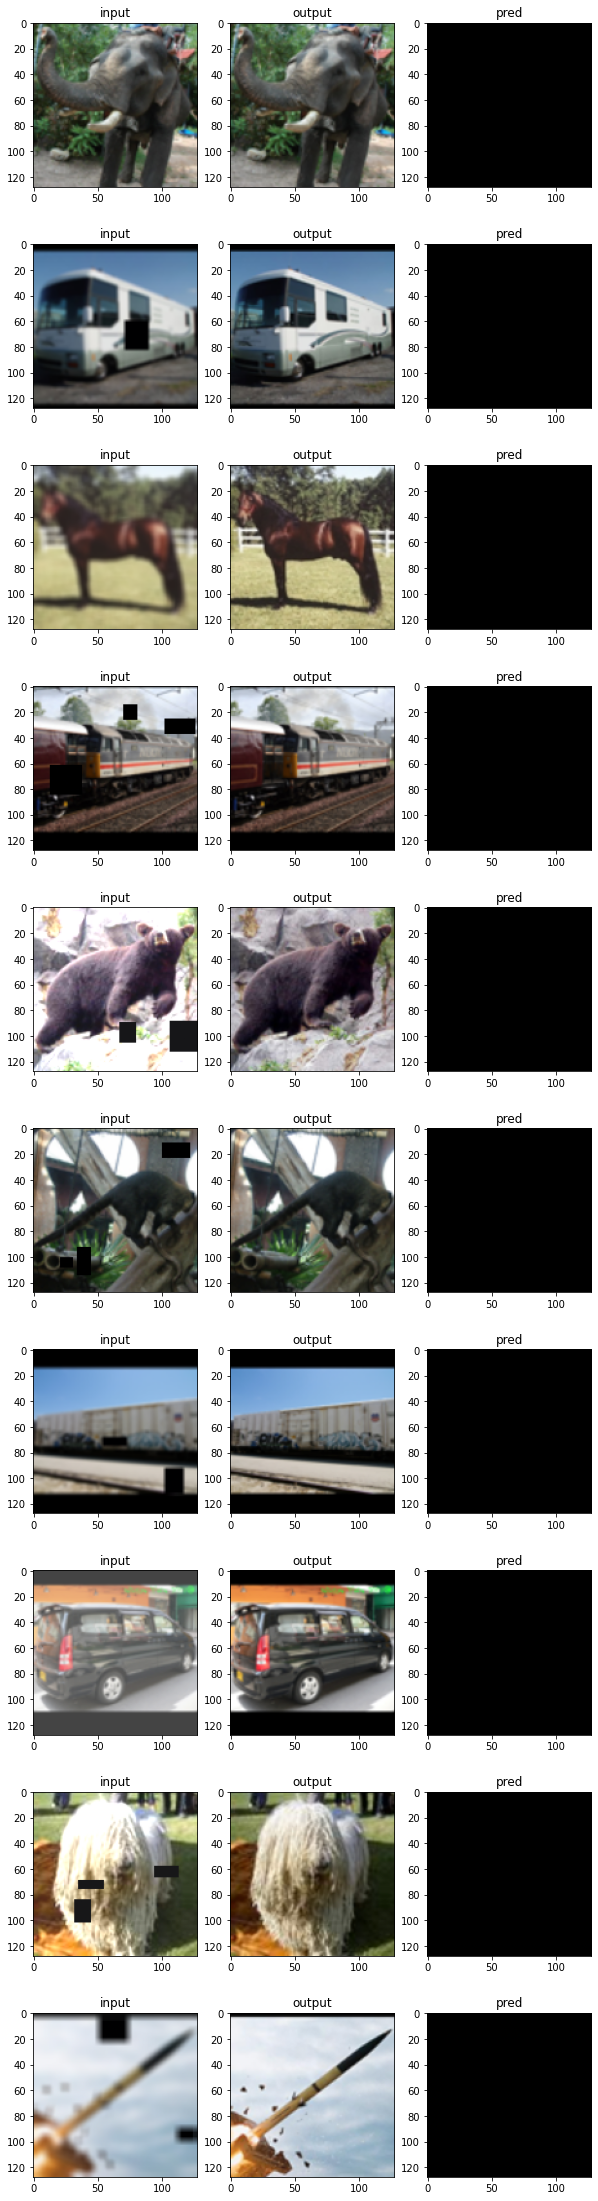

In [5]:
visualize_prediction(
    model=None,
    dataset=datasets['unlabeled'],
)

## Define model
![alt text](pics/ae.png "Title")

In [6]:
class AutoEncoder(nn.Module):
    
    def __init__(
        self,
        downlayers: nn.Module,
        middlelayers: nn.Module,
        uplayers: nn.Module,
    ) -> None:
        
        super().__init__()
        
        self.down = downlayers()
        self.middle = middlelayers()
        self.up = uplayers()
        
    def forward(
        self,
        x: torch.Tensor,
        embedding: bool=True,
        **kwargs,
    ) -> torch.Tensor:
        
        x = self.down(x)
        
        middle = self.middle(x, embedding)
        
        if embedding:
            return middle
            
        
        x = self.up(middle)
        
        return {
            'pred_image': x.sigmoid(),
            'latent_repr': middle,
        }
    
class CompressionMiddleLayer(nn.Module):
    
    def __init__(
        self,
        expected_dim: tuple = (image_size[0] // 32, image_size[1] // 32),
        hidden_dim: int=512,
        **kwargs,
    ) -> None:
        
        super().__init__()
        
        self.agg = nn.AdaptiveAvgPool2d((1, 1))
        self.up = nn.ConvTranspose2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=expected_dim,
            stride=2,
        )
    
    def forward(
        self,
        x: torch.Tensor,
        embedding: bool=True,
    ) -> torch.Tensor:
        
        x = self.agg(x)
        
        if embedding:
            
            return x.flatten(
                start_dim=1,
                end_dim=-1,
            )
        
        x = self.up(x)
        
        return x
    
class MiddleLayer(nn.Module):
    
    def __init__(
        self,
        **kwargs,
    ) -> None:
        
        super().__init__()
        
        self.agg = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(
        self,
        x: torch.Tensor,
        embedding: bool=True,
    ) -> torch.Tensor:
        
        if embedding:
            
            x = self.agg(x).flatten(start_dim=1, end_dim=-1)
            return x
        
        return x

In [7]:
mode = 'no_compress'

bottleneck = {
    'compress': CompressionMiddleLayer,
    'no_compress': MiddleLayer,
}


model = AutoEncoder(
    downlayers=resnet18,
    middlelayers=bottleneck[mode],
    uplayers=deconv_resnet18,
).to(device)

## Define trainer params

In [9]:
lr=8e-4

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=lr,
    weight_decay=1e-3,
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=lr,
    steps_per_epoch=len(dataloaders['unlabeled']),
    epochs=epochs,
)
loss = AELoss(weights=[1e4, 1])

save_path=f'metrics/AE/epoch={epochs}_bs={bs}_lr={lr}_loss={loss.__class__.__name__}_bn-mode={mode}'
visualiser = Collector(
    root_graphics=save_path,
    root_desc=save_path,
    phases=list(transformations.keys()),
)

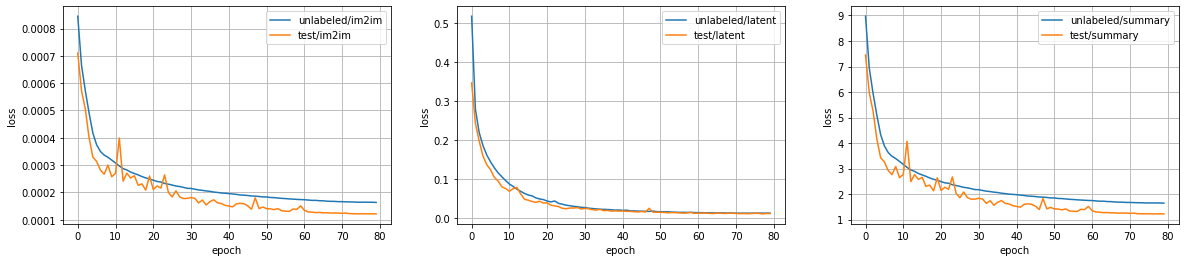

In [10]:
trainer(model, optimizer, scheduler, dataloaders, epochs, device, loss, visualiser, save_path)

## Lets visualise the predictions

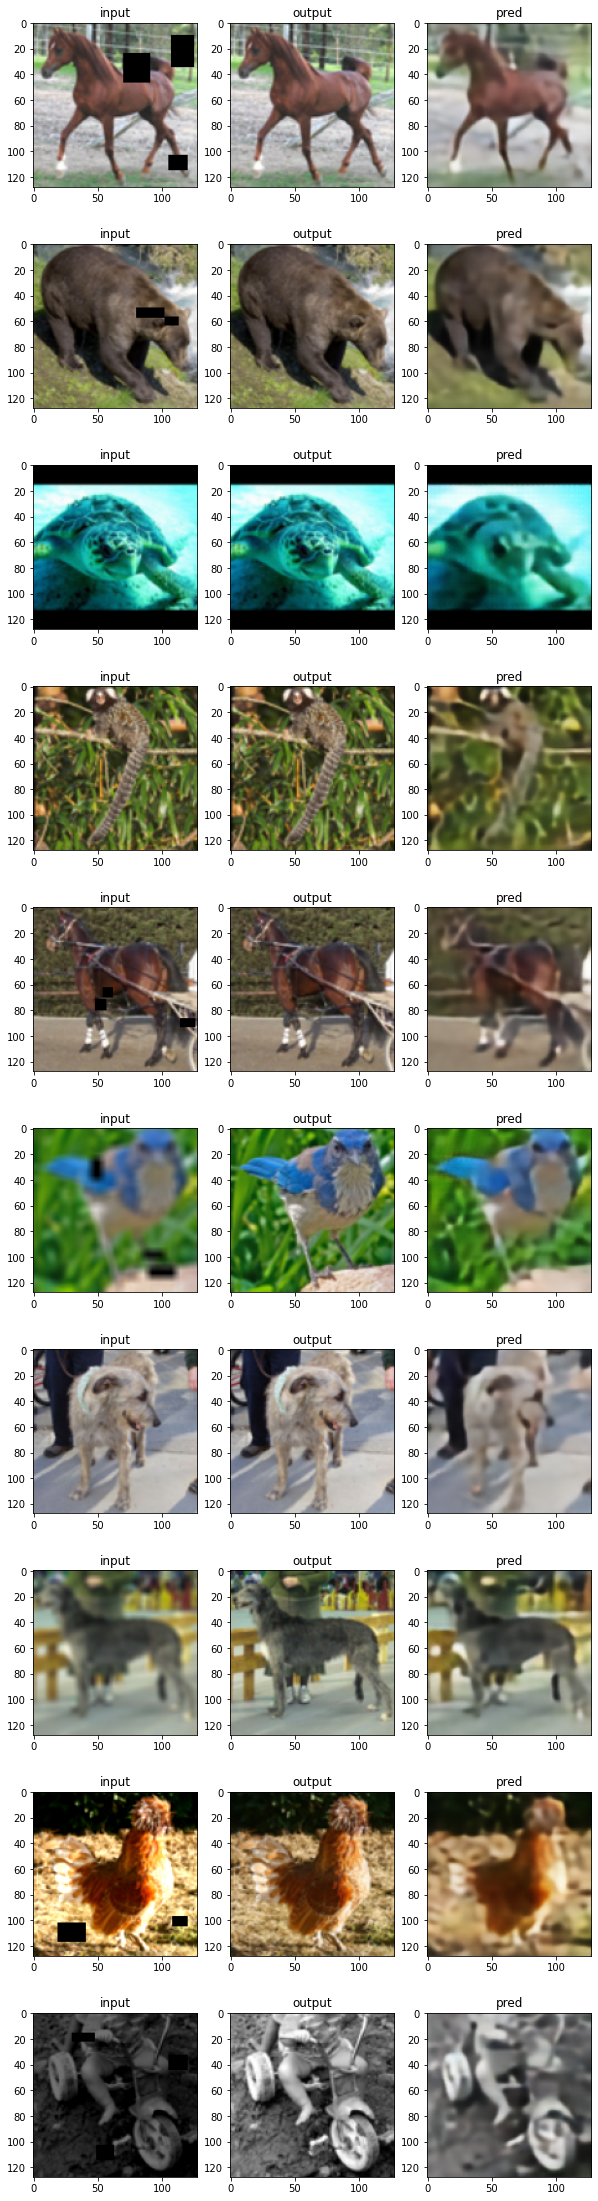

In [11]:
visualize_prediction(model, datasets['unlabeled'], save_path)

In [13]:
torch.save(model.down.state_dict(), 'resnet18.pth')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  6.41it/s]


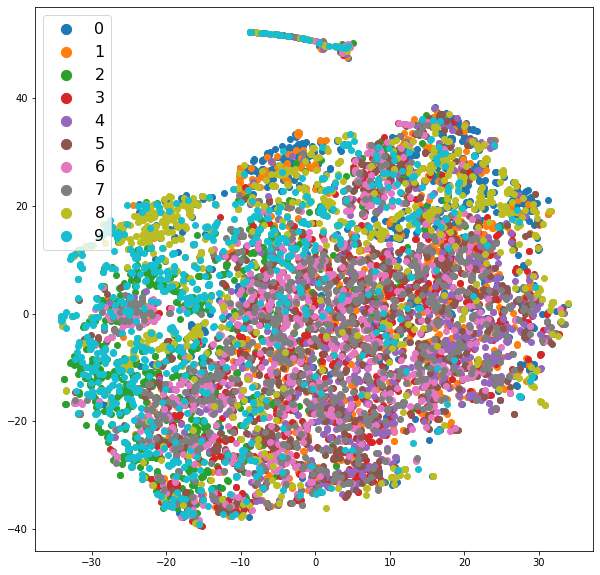

In [12]:
plot_latent_tsne(model, dataloaders['test'], save_path)

In [14]:
model.load_state_dict?

Signature:
model.load_state_dict(
    state_dict: 'OrderedDict[str, Tensor]',
    strict: bool = True,
)
Docstring:
Copies parameters and buffers from :attr:`state_dict` into
this module and its descendants. If :attr:`strict` is ``True``, then
the keys of :attr:`state_dict` must exactly match the keys returned
by this module's :meth:`~torch.nn.Module.state_dict` function.

Args:
    state_dict (dict): a dict containing parameters and
        persistent buffers.
    strict (bool, optional): whether to strictly enforce that the keys
        in :attr:`state_dict` match the keys returned by this module's
        :meth:`~torch.nn.Module.state_dict` function. Default: ``True``

Returns:
    ``NamedTuple`` with ``missing_keys`` and ``unexpected_keys`` fields:
        * **missing_keys** is a list of str containing the missing keys
        * **unexpected_keys** is a list of str containing the unexpected keys

Note:
    If a parameter or buffer is registered as ``None`` and its corresponding key

## Lets trace the model

In [ ]:
def convert_embeddings(
    path: str,
    transforms,
) -> torch.Tensor:
    
    batch = torch.load(path).mul_(255).permute(0, 2, 3, 1).numpy().astype(np.uint8)
    new_batch = []
    
    for image in batch:
        new_batch.append(
            transforms(image=image)['image'],
        )
        
    new_batch = torch.stack(new_batch)
    
    return new_batch

In [ ]:
traced_module = torch.jit.trace(model.cpu(), torch.randn(1, 3, image_size[0], image_size[1]))
torch.jit.save(traced_module, os.path.join(save_path, 'model_traced.pt'))

In [ ]:
loaded = torch.jit.load(os.path.join(save_path, 'model_traced.pt'))
batch = convert_embeddings('health_dataset.pth', transformations['test'])

with torch.no_grad():
    embeddings = loaded(batch.cpu()).cpu()
    
torch.save(embeddings, os.path.join(save_path, 'embeddings.pth'))